In [1]:
import os
import subprocess
import pandas as pd
import rasterio
import matplotlib.pyplot as plt

In [2]:
# 📂 Rutas
ruta_csv = r"C:/Proyectos/2024/Conejos/mapas/pozos.csv"
ruta_salida = r"C:/Proyectos/2024/Conejos/mapas/interpolados"
os.makedirs(ruta_salida, exist_ok=True)

In [3]:
os.environ["PATH"] += r";C:\OSGeo4W\bin"
subprocess.run(["gdal_grid", "--version"])

CompletedProcess(args=['gdal_grid', '--version'], returncode=0)

In [4]:
# 📌 Ruta del ejecutable de gdal_grid
gdal_grid_exe = r"C:\OSGeo4W\bin\gdal_grid.exe"

In [5]:
# 📌 Configuración
campo_x = "x_nad27"
campo_y = "y_nad27"
años_validos = [2005, 2006, 2007, 2009, 2010, 2011, 2012, 2015, 2016, 2017, 2018] ##

In [7]:
# 📥 Leer CSV con Pandas
df = pd.read_csv(ruta_csv)

In [9]:
for anio in años_validos:
    campo_valor = str(anio)

    datos = df[
        df["x_nad27"].notna() &
        df["y_nad27"].notna() &
        df[campo_valor].notna()
    ][["x_nad27", "y_nad27", campo_valor]]

    if len(datos) < 3:
        print(f"⚠️ Solo {len(datos)} valores válidos para {campo_valor}, se omite.")
        continue

    # Renombrar la columna de valores para que GDAL la acepte
    col_z = f"val_{campo_valor}"
    datos = datos.rename(columns={campo_valor: col_z})

    # Calcular límites
    min_x, max_x = datos["x_nad27"].min(), datos["x_nad27"].max()
    min_y, max_y = datos["y_nad27"].min(), datos["y_nad27"].max()

    # Guardar CSV temporal limpio
    temp_csv = os.path.join(ruta_salida, f"temp_{campo_valor}.csv")
    datos.to_csv(temp_csv, index=False)

    salida_raster = os.path.join(ruta_salida, f"nivel_{campo_valor}.tif")

    # Comando GDAL
    comando = [
        "gdal_grid",
        "-a", "invdist:power=2.0:smoothing=0.0",
        "-txe", str(min_x), str(max_x),
        "-tye", str(max_y), str(min_y),
        "-outsize", "500", "500",
        "-zfield", col_z,
        "-oo", "X_POSSIBLE_NAMES=x_nad27",
        "-oo", "Y_POSSIBLE_NAMES=y_nad27",
        "-a_srs", "+proj=utm +zone=13 +datum=NAD27 +units=m +no_defs",  # 👈 aquí  
        "-of", "GTiff",
        f"CSV:{temp_csv}",
        salida_raster
    ]

    print(f"🔹 Ejecutando: {' '.join(comando)}")
    result = subprocess.run(comando, capture_output=True, text=True)

    if result.returncode != 0:
        print(f"⚠️ Error con {campo_valor}")
        print("STDOUT:", result.stdout.strip())
        print("STDERR:", result.stderr.strip())
    else:
        print(f"✅ Guardado: {salida_raster}")


🔹 Ejecutando: gdal_grid -a invdist:power=2.0:smoothing=0.0 -txe 285776 354918 -tye 3517209 3411260 -outsize 500 500 -zfield val_2005 -oo X_POSSIBLE_NAMES=x_nad27 -oo Y_POSSIBLE_NAMES=y_nad27 -a_srs +proj=utm +zone=13 +datum=NAD27 +units=m +no_defs -of GTiff CSV:C:/Proyectos/2024/Conejos/mapas/interpolados\temp_2005.csv C:/Proyectos/2024/Conejos/mapas/interpolados\nivel_2005.tif
✅ Guardado: C:/Proyectos/2024/Conejos/mapas/interpolados\nivel_2005.tif
🔹 Ejecutando: gdal_grid -a invdist:power=2.0:smoothing=0.0 -txe 285776 354918 -tye 3517209 3411260 -outsize 500 500 -zfield val_2006 -oo X_POSSIBLE_NAMES=x_nad27 -oo Y_POSSIBLE_NAMES=y_nad27 -a_srs +proj=utm +zone=13 +datum=NAD27 +units=m +no_defs -of GTiff CSV:C:/Proyectos/2024/Conejos/mapas/interpolados\temp_2006.csv C:/Proyectos/2024/Conejos/mapas/interpolados\nivel_2006.tif
✅ Guardado: C:/Proyectos/2024/Conejos/mapas/interpolados\nivel_2006.tif
🔹 Ejecutando: gdal_grid -a invdist:power=2.0:smoothing=0.0 -txe 285776 354918 -tye 3517209 341

In [25]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib
import contextily as ctx

# Config de color por tipo de dato (negativo: profundidades; positivo: alturas)
VALOR_MIN_NEG = -140   # ajusta si quieres
VALOR_MAX_NEG = 0
VALOR_MIN_POS = 0
VALOR_MAX_POS = 140

for anio in años_validos:
    campo_valor = str(anio)

    # 1) Filtrar datos válidos y finitos
    datos = df[['x_nad27', 'y_nad27', campo_valor]].copy()
    datos = datos.replace([np.inf, -np.inf], np.nan).dropna(subset=['x_nad27','y_nad27', campo_valor])

    # Evitar problemas de límites vacíos
    if len(datos) < 3:
        print(f"⚠️ Solo {len(datos)} valores válidos para {campo_valor}, se omite.")
        continue

    # 2) GeoDataFrame en NAD27 (EPSG:4267) y reproyectar a 3857 para el basemap
    gdf = gpd.GeoDataFrame(
        datos,
        geometry=gpd.points_from_xy(datos['x_nad27'], datos['y_nad27']),
        crs='EPSG:4267'           # NAD27 en grados
    )
    gdf_3857 = gdf.to_crs(3857)

    # 3) Bounds robustos + padding mínimo (en metros)
    xmin, ymin, xmax, ymax = gdf_3857.total_bounds
    if not np.all(np.isfinite([xmin, ymin, xmax, ymax])):
        print(f"⚠️ Bounds no finitos para {campo_valor}, se omite.")
        continue

    span_x = xmax - xmin
    span_y = ymax - ymin
    if span_x == 0: span_x = 200  # 200 m de span mínimo
    if span_y == 0: span_y = 200

    pad_x = max(span_x * 0.05, 100)  # al menos 100 m de margen
    pad_y = max(span_y * 0.05, 100)

    # 4) Elegir cmap y límites según signo de los datos
    median_val = float(gdf_3857[campo_valor].median())
    if median_val < 0:
        # Valores NEGATIVOS (profundidades): profundo = más negativo -> más oscuro con 'viridis'
        bounds = np.arange(VALOR_MIN_NEG, VALOR_MAX_NEG + 10, 10)  # -140, -130, ..., 0
        cmap = matplotlib.colormaps.get_cmap('viridis')
        norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N, clip=True)
        vmin, vmax = VALOR_MIN_NEG, VALOR_MAX_NEG
    else:
        # Valores POSITIVOS: profundo = mayor valor -> más oscuro con 'viridis_r'
        bounds = np.arange(VALOR_MIN_POS, VALOR_MAX_POS + 10, 10)  # 0,10,...,140
        cmap = matplotlib.colormaps.get_cmap('viridis_r')
        norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N, clip=True)
        vmin, vmax = VALOR_MIN_POS, VALOR_MAX_POS

    # 5) Graficar
    fig, ax = plt.subplots(figsize=(7, 7))
    sc = ax.scatter(
        gdf_3857.geometry.x, gdf_3857.geometry.y,
        c=gdf_3857[campo_valor],
        cmap=cmap, norm=norm,
        s=30, edgecolors='k', linewidths=0.3, zorder=30
    )

    ax.set_xlim(xmin - pad_x, xmax + pad_x)
    ax.set_ylim(ymin - pad_y, ymax + pad_y)

    # Basemap en 3857
    ctx.add_basemap(ax, source=ctx.providers.Esri.WorldStreetMap)

    # Colorbar categorizada cada 10 m
    cbar = fig.colorbar(sc, ax=ax, fraction=0.035, pad=0.02, ticks=bounds)
    cbar.set_label("Nivel piezométrico (m)")

    ax.set_xlabel("Longitud"); ax.set_ylabel("Latitud")
    ax.set_title(f"Valores para el año {campo_valor}")
    ax.set_aspect('equal', adjustable='box')

    plt.tight_layout()
    # fig.savefig(os.path.join(ruta_salida, f"puntos_{campo_valor}.png"), dpi=300)
    # plt.close(fig)
    plt.show()


⚠️ Bounds no finitos para 2005, se omite.
⚠️ Bounds no finitos para 2006, se omite.
⚠️ Bounds no finitos para 2007, se omite.
⚠️ Bounds no finitos para 2009, se omite.
⚠️ Bounds no finitos para 2010, se omite.
⚠️ Bounds no finitos para 2011, se omite.
⚠️ Bounds no finitos para 2012, se omite.
⚠️ Bounds no finitos para 2015, se omite.
⚠️ Bounds no finitos para 2016, se omite.
⚠️ Bounds no finitos para 2017, se omite.
⚠️ Bounds no finitos para 2018, se omite.


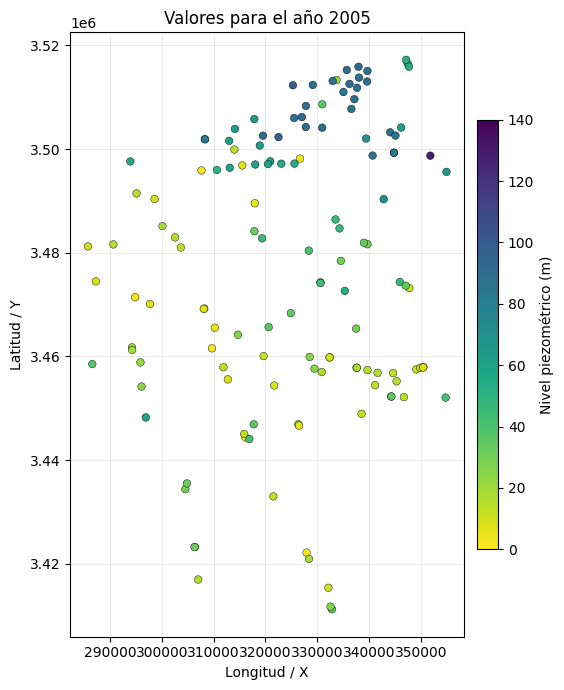

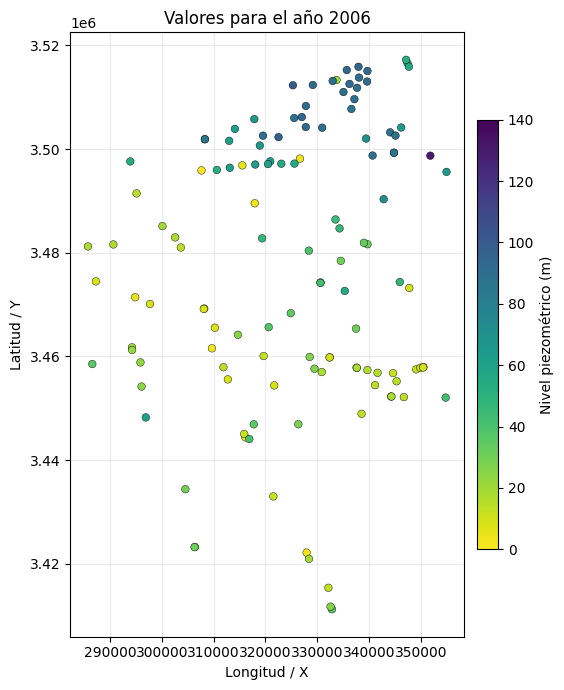

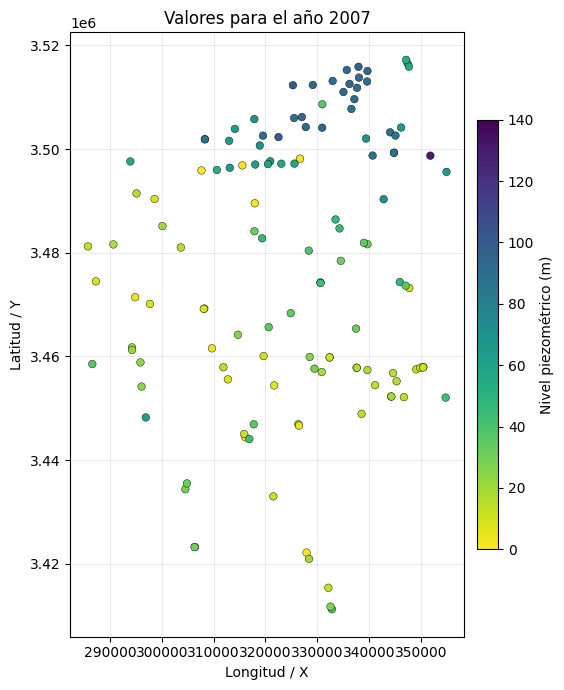

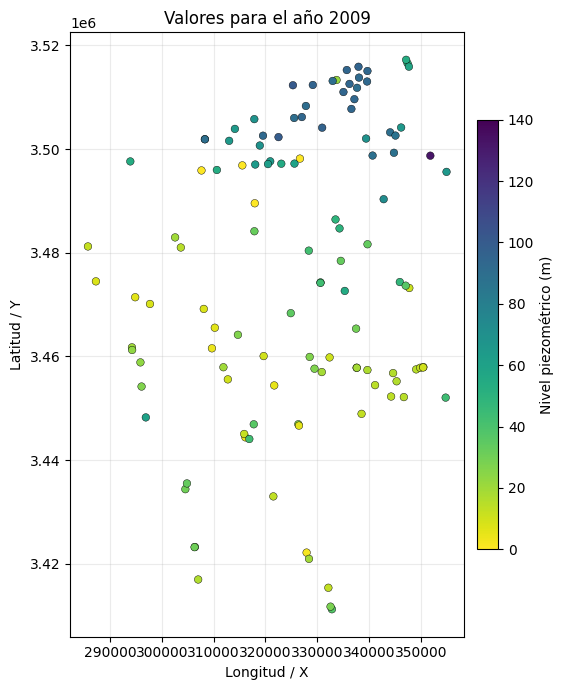

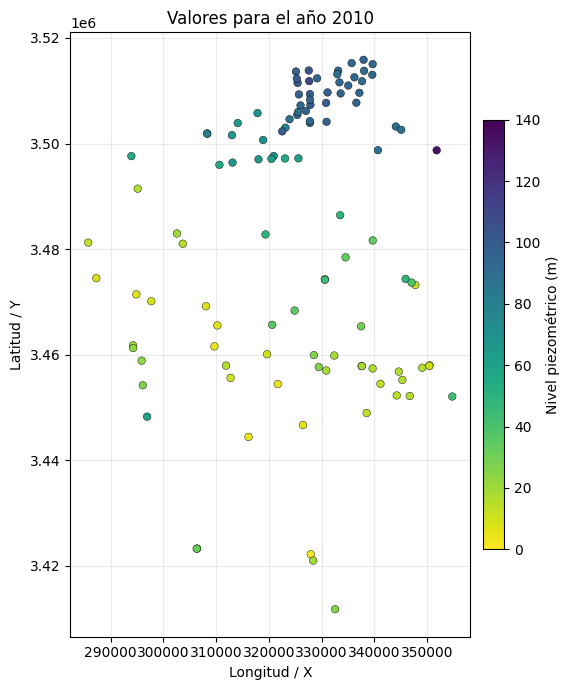

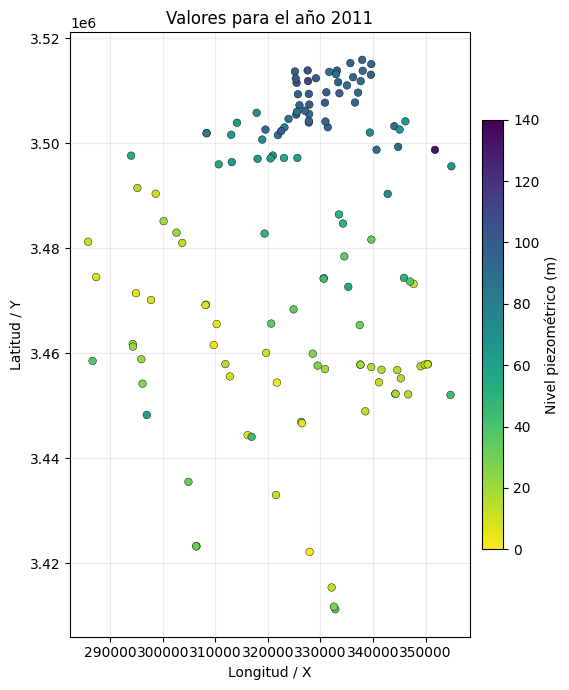

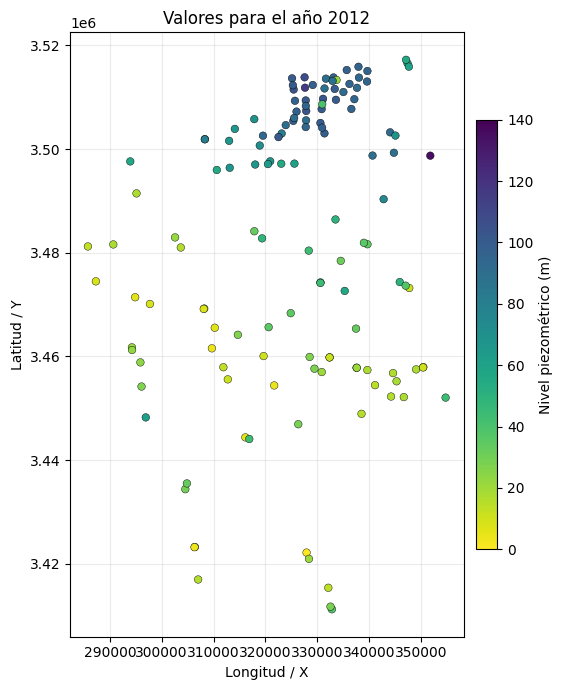

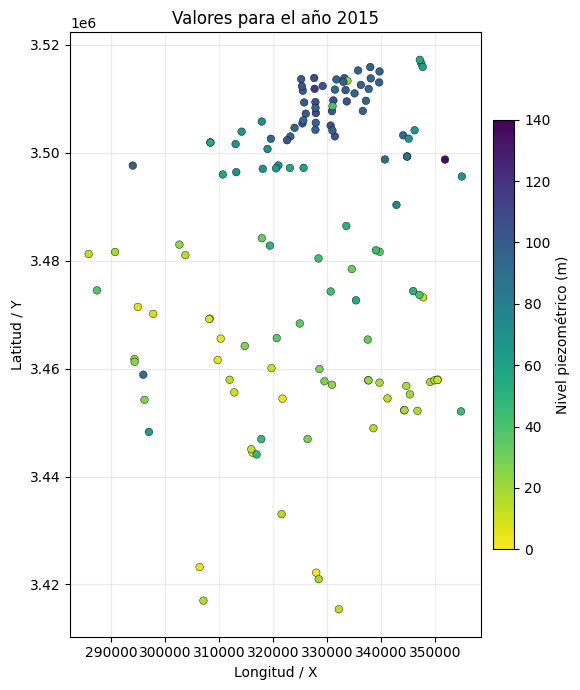

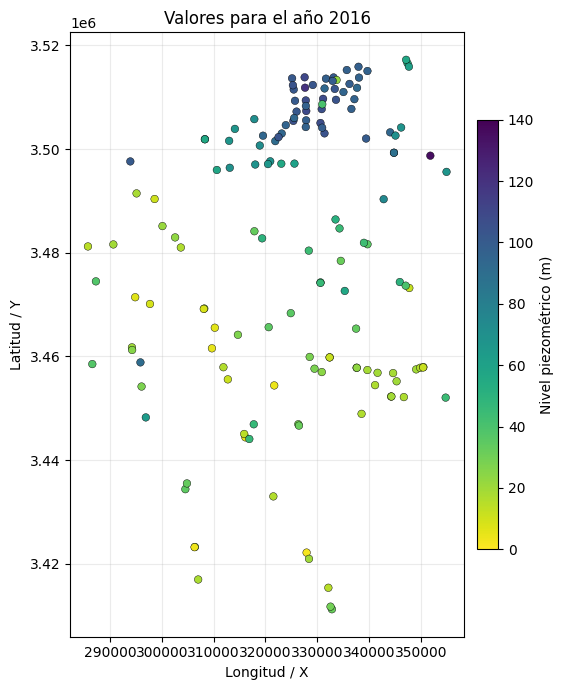

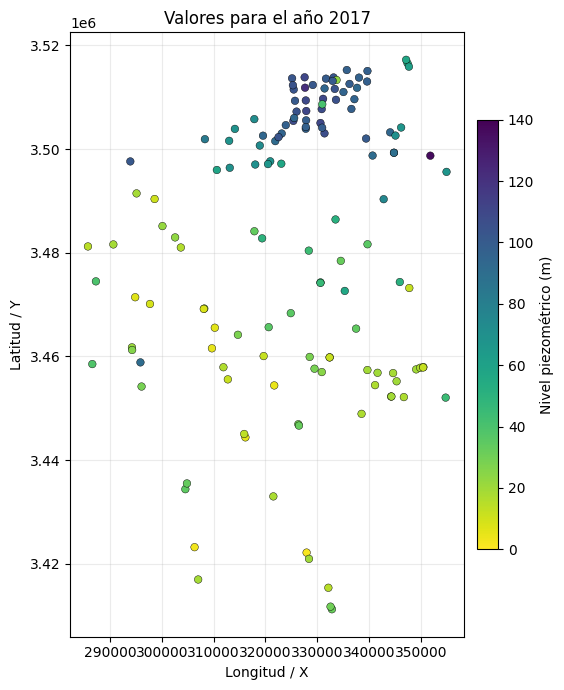

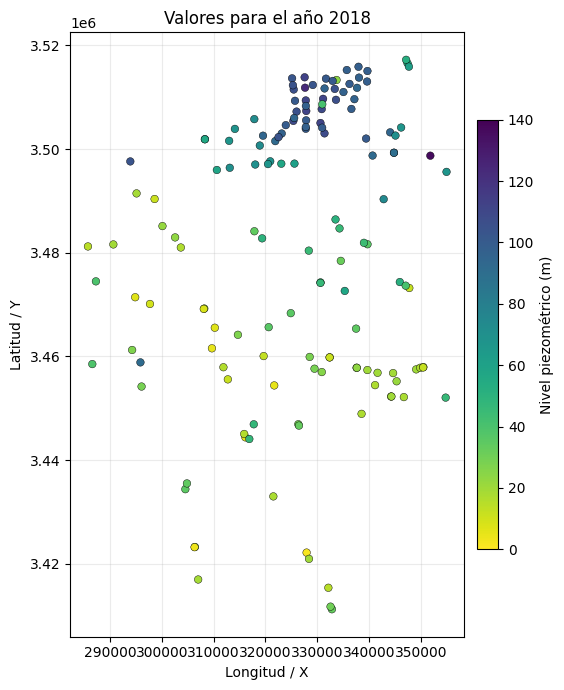

In [26]:
VMIN_GLOBAL = 0     # prof. somera
VMAX_GLOBAL = 140   # prof. profunda

for anio in años_validos:
    campo_valor = str(anio)

    # Filtrar datos válidos
    datos = df[
        df["x_nad27"].notna() &
        df["y_nad27"].notna() &
        df[campo_valor].notna()
    ][["x_nad27", "y_nad27", campo_valor]]

    if len(datos) < 3:
        print(f"⚠️ Solo {len(datos)} valores válidos para {campo_valor}, se omite.")
        continue

    # --- FIGURA DE PUNTOS CON PALETA INVERTIDA ---
    fig, ax = plt.subplots(figsize=(7, 7))

    # Si prefieres que cada año use su propio rango, comenta VMIN/VMAX y usa los locales:
    # vmin, vmax = datos[campo_valor].min(), datos[campo_valor].max()
    vmin, vmax = VMIN_GLOBAL, VMAX_GLOBAL

    sc = ax.scatter(
        datos["x_nad27"], datos["y_nad27"],
        c=datos[campo_valor],
        cmap='viridis_r',          # <<< paleta invertida (profundo = oscuro)
        vmin=vmin, vmax=vmax,
        s=30, edgecolors='k', linewidths=0.3, zorder=10
    )

    cbar = fig.colorbar(sc, ax=ax, fraction=0.035, pad=0.02)
    cbar.set_label("Nivel piezométrico (m)")

    ax.set_xlabel("Longitud / X")
    ax.set_ylabel("Latitud / Y")
    ax.set_title(f"Valores para el año {campo_valor}")
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True, alpha=0.25)

    # (Opcional) si tienes el límite del acuífero en la MISMA proyección que x_nad27/y_nad27:
    # gdf_limite.boundary.plot(ax=ax, color='black', linewidth=1.4, zorder=12)

    plt.tight_layout()
    # png_salida = os.path.join(ruta_salida, f"pun_{campo_valor}.png")
    # fig.savefig(png_st()
    # fig.savefig(os.path.join(ruta_salida, f"puntos_{campo_valor}.png"), dpi=300)
    # plt.close(fig)
    plt.show()
